In [194]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import pandas as pd

In [195]:
df = pd.read_csv('./train.csv')

In [196]:
# Load data

data = df.values.astype(np.float32)
np.random.shuffle(data)
X = data[:, 1:]
Y = data[:, 0]

Xtrain = X[:-1000]
Ytrain = Y[:-1000]
Xtest  = X[-1000:]
Ytest  = Y[-1000:]

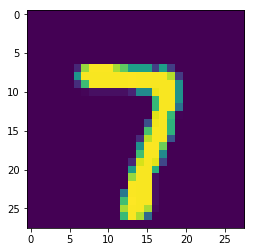

In [197]:
s = np.reshape(Xtrain[0], (28, 28))
plt.imshow(s)
plt.show()

In [198]:
# normalizie the data

mu = Xtrain.mean(axis=0)
std = Xtrain.std(axis=0)

np.place(std, std == 0, 1)

Xtrain = (Xtrain - mu) / std
Xtest = (Xtest - mu) / std

In [199]:
# change y to hot encoder

def y2indicator(y):

    y = y.astype(np.int32)
    ind = np.zeros((len(y), 10))

    for i in range(len(y)):
        ind[i, y[i]] = 1
        
    return ind 

In [200]:
def error_rate(p, t):
    return np.mean(p != t)

In [201]:
def relu(a):
    return a * (a > 0)

In [202]:
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In [203]:
# data is ready

Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)
Ytest = Ytest.astype(np.float32)
Ytrain_ind = Ytrain_ind.astype(np.float32)
Ytest_ind = Ytest_ind.astype(np.float32)

In [273]:
# initial values

max_iter = 15
print_period = 100

lr = 0.0004
reg = 0.01 #smooth parameter

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

M = 300
K = 10

In [274]:
W1_init = np.random.randn(D, M) / 28
b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b2_init = np.zeros(K)

In [352]:
# step 2: define theano variables and expressions
thX = T.matrix('X')
thT = T.matrix('T')
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

In [353]:
# we can use the built-in theano functions to do relu and softmax
thZ = relu( thX.dot(W1) + b1 )  
thY = T.nnet.softmax( thZ.dot(W2) + b2 )

In [354]:
# define the cost function and prediction
cost = -(thT * T.log(thY)).sum()

#L1 regularization
#cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())

#L2 regularization
#cost = -(thT * T.log(thY)).sum() + reg*(np.abs(W1).sum() + np.abs(b1).sum() + np.abs(W2).sum() + np.abs(b2).sum())

prediction = T.argmax(thY, axis=1)

In [355]:
mu = 0.9

In [334]:
#without momentum
""" 

update_W1 = W1 - lr*T.grad(cost, W1)
update_b1 = b1 - lr*T.grad(cost, b1)
update_W2 = W2 - lr*T.grad(cost, W2)
update_b2 = b2 - lr*T.grad(cost, b2)

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)]

"""

' \n\nupdate_W1 = W1 - lr*T.grad(cost, W1)\nupdate_b1 = b1 - lr*T.grad(cost, b1)\nupdate_W2 = W2 - lr*T.grad(cost, W2)\nupdate_b2 = b2 - lr*T.grad(cost, b2)\n\nupdates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)]\n\n'

In [335]:
# this is equivalent to the line above
"""
params = [W1, b1, W2, b2]
updates = [(p, p-lr*T.grad(cost, p)) for p in params]
"""

In [336]:
#with momentum
"""

vW1_init = np.zeros((D,M))
vb1_init = np.zeros(M)
vW2_init = np.zeros((M,K))
vb2_init = np.zeros(K)

vW1 = theano.shared(vW1_init, 'dW1')
vb1 = theano.shared(vb1_init, 'db1')
vW2 = theano.shared(vW2_init, 'dW2')
vb2 = theano.shared(vb2_init, 'db2')

update_vW1 = mu * vW1 - lr * T.grad(cost, W1)
update_vb1 = mu * vb1 - lr * T.grad(cost, b1)
update_vW2 = mu * vW2 - lr * T.grad(cost, W2)
update_vb2 = mu * vb2 - lr * T.grad(cost, b2)

update_W1 = W1 + mu * vW1 - lr * T.grad(cost, W1)
update_b1 = b1 + mu * vb1 - lr * T.grad(cost, b1)
update_W2 = W2 + mu * vW2 - lr * T.grad(cost, W2)
update_b2 = b2 + mu * vb2 - lr * T.grad(cost, b2)

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] + [(vW1, update_vW1), (vb1, update_vb1), (vW2, update_vW2), (vb2, update_vb2)]


"""


"\n\nvW1_init = np.zeros((D,M))\nvb1_init = np.zeros(M)\nvW2_init = np.zeros((M,K))\nvb2_init = np.zeros(K)\n\nvW1 = theano.shared(vW1_init, 'dW1')\nvb1 = theano.shared(vb1_init, 'db1')\nvW2 = theano.shared(vW2_init, 'dW2')\nvb2 = theano.shared(vb2_init, 'db2')\n\nupdate_W1 = W1 + mu * vW1 - lr * T.grad(cost, W1)\nupdate_b1 = b1 + mu * vb1 - lr * T.grad(cost, b1)\nupdate_W2 = W2 + mu * vW2 - lr * T.grad(cost, W2)\nupdate_b2 = b2 + mu * vb2 - lr * T.grad(cost, b2)\n\nupdate_vW1 = mu * vW1 - lr * T.grad(cost, W1)\nupdate_vb1 = mu * vb1 - lr * T.grad(cost, b1)\nupdate_vW2 = mu * vW2 - lr * T.grad(cost, W2)\nupdate_vb2 = mu * vb2 - lr * T.grad(cost, b2)\n\nupdates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] + [(vW1, update_vW1), (vb1, update_vb1), (vW2, update_vW2), (vb2, update_vb2)]\n\n\n"

In [337]:
# this is equivalent to the line above
""" 
params = [W1, b1, W2, b2]
vparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

updates = [(p, p + mu * vp -lr * T.grad(cost, p)) for p, vp in zip(params, vparams)] + [(vp, mu * vp - lr * T.grad(cost, p)) for p, vp in zip(params, vparams)]
"""    

' \nparams = [W1, b1, W2, b2]\nvparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]\n\nupdates = [(p, p + mu * vp -lr * T.grad(cost, p)) for p, vp in zip(params, vparams)] + [(vp, mu * vp - lr * T.grad(cost, p)) for p, vp in zip(params, vparams)]\n'

In [348]:
#with nesterov momentum
"""
vW1_init = np.zeros((D,M))
vb1_init = np.zeros(M)
vW2_init = np.zeros((M,K))
vb2_init = np.zeros(K)

vW1 = theano.shared(vW1_init, 'dW1')
vb1 = theano.shared(vb1_init, 'db1')
vW2 = theano.shared(vW2_init, 'dW2')
vb2 = theano.shared(vb2_init, 'db2')

update_vW1 = mu * vW1 - lr * T.grad(cost, W1)
update_vb1 = mu * vb1 - lr * T.grad(cost, b1)
update_vW2 = mu * vW2 - lr * T.grad(cost, W2)
update_vb2 = mu * vb2 - lr * T.grad(cost, b2)

update_W1 = W1 + mu * (mu * vW1 - lr * T.grad(cost, W1)) - lr * T.grad(cost, W1)
update_b1 = b1 + mu * (mu * vb1 - lr * T.grad(cost, b1)) - lr * T.grad(cost, b1)
update_W2 = W2 + mu * (mu * vW2 - lr * T.grad(cost, W2)) - lr * T.grad(cost, W2)
update_b2 = b2 + mu * (mu * vb2 - lr * T.grad(cost, b2)) - lr * T.grad(cost, b2)

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] + [(vW1, update_vW1), (vb1, update_vb1), (vW2, update_vW2), (vb2, update_vb2)]
"""

In [356]:
#This line is equivalent to the line above

params = [W1, b1, W2, b2]
vparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

updates = [(p, p + mu * (mu * vp - lr * T.grad(cost, p)) - lr * T.grad(cost, p)) for p, vp in zip(params, vparams)] + [(vp, mu * vp - lr * T.grad(cost, p)) for p, vp in zip(params, vparams)]


In [357]:
train = theano.function(
    inputs=[thX, thT],
    updates = updates
)

In [358]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

Cost / err at iteration i=0, j=0, cost_value: 1446.945, error: 0.424
Cost / err at iteration i=1, j=0, cost_value: 158.719, error: 0.037
Cost / err at iteration i=2, j=0, cost_value: 200.746, error: 0.032
Cost / err at iteration i=3, j=0, cost_value: 216.723, error: 0.022
Cost / err at iteration i=4, j=0, cost_value: 111.233, error: 0.020
Cost / err at iteration i=5, j=0, cost_value: 116.169, error: 0.022
Cost / err at iteration i=6, j=0, cost_value: 207.082, error: 0.019
Cost / err at iteration i=7, j=0, cost_value: 165.902, error: 0.024
Cost / err at iteration i=8, j=0, cost_value: 137.237, error: 0.019
Cost / err at iteration i=9, j=0, cost_value: 108.116, error: 0.017
Cost / err at iteration i=10, j=0, cost_value: 94.364, error: 0.018
Cost / err at iteration i=11, j=0, cost_value: 99.117, error: 0.015
Cost / err at iteration i=12, j=0, cost_value: 96.586, error: 0.015
Cost / err at iteration i=13, j=0, cost_value: 98.276, error: 0.018
Cost / err at iteration i=14, j=0, cost_value: 

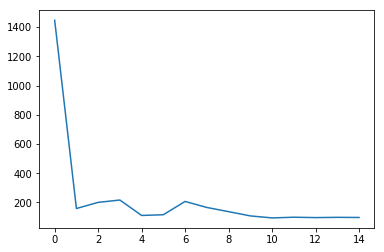

In [359]:
costs = []
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            print("Cost / err at iteration i=%d, j=%d, cost_value: %.3f, error: %.3f" % (i, j, cost_val, err))
            costs.append(cost_val)

plt.plot(costs)
plt.show()